In [97]:
# Only Change bag_name

In [44]:
# Imports
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np
import os

In [45]:
def create_folder(path, folder_name):
    # Join the path and folder name
    folder_path = os.path.join(path, folder_name)
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_name}' created in '{path}'")
    else:
        print(f"Folder '{folder_name}' already exists in '{path}'")

In [46]:
# read rosbag
bag_name = 'my_data_test1'
path_bag = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/" + bag_name + ".bag"
bag = bagpy.bagreader(path_bag)

[INFO]  Data folder /home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/my_data_test1 already exists. Not creating.


In [47]:
# extract topics of interest
odom_data = pd.read_csv(bag.message_by_topic('/odom'))
# position_data = pd.read_csv(bag.message_by_topic('/vehicle_position'))
# velocity_data = pd.read_csv(bag.message_by_topic('/vehicle_velocities'))
estimation_data = pd.read_csv(bag.message_by_topic('/encoder_state_estimation'))

#TODO comment
cmd_data = pd.read_csv(bag.message_by_topic('/cmd_vel'))

In [48]:
# Select the Desired columns in odom_data
desired_columns = ['Time', 'pose.pose.position.x', 'pose.pose.position.y', 
                   'pose.pose.orientation.z',
                   'twist.twist.linear.x', 'twist.twist.linear.y', 
                   'twist.twist.linear.z', 'twist.twist.angular.z']

# Select only the desired columns
odom_data = odom_data[desired_columns]
estimation_data = estimation_data[desired_columns]

# Rename Columns
odom_data = odom_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity',
    'pose.pose.position.x': 'position_x',
    'pose.pose.position.y': 'position_y',
    'pose.pose.orientation.z': 'theta_z',
    'twist.twist.linear.x': 'velocity_x',
    'twist.twist.linear.y': 'velocity_y',
    'twist.twist.angular.z': 'omega_z'
})

estimation_data = estimation_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity_encoder',
    'pose.pose.position.x': 'position_x_encoder',
    'pose.pose.position.y': 'position_y_encoder',
    'pose.pose.orientation.z': 'theta_z_encoder',
    'twist.twist.linear.x': 'velocity_x_encoder',
    'twist.twist.linear.y': 'velocity_y_encoder',
    'twist.twist.angular.z': 'omega_z_encoder'
})

# position_data = position_data.rename(columns={
#     'x' : "encoder_x",
#     'y' : "encoder_y",
#     'z' : "encoder_theta"
# })

# velocity_data = velocity_data.rename(columns={
#     'x' : "encoder_velocity",
#     'y' : "Null",
#     'z' : "encoder_omega"
# })

#TODO comment
cmd_data = cmd_data.rename(columns={
    'data' : "cmd_vel",
})


In [49]:
# # Note: select odom offset to use for all topics to uniify time
# Calculate Time offset
offset_odom = odom_data['Time'].iloc[0]
# offset_pos  = position_data['Time'].iloc[0]
# offset_vel  = velocity_data['Time'].iloc[0]
# offset_cmd = cmd_data['Time'].iloc[0] #TODO comment

# Subtract the offset from all values in the "Time" column
odom_data['Time'] = odom_data['Time'] - offset_odom
estimation_data['Time'] = estimation_data['Time'] - offset_odom
# position_data['Time'] = position_data['Time'] - offset_odom
# velocity_data['Time'] = velocity_data['Time'] - offset_odom

cmd_data['Time'] = cmd_data['Time'] - offset_odom #TODO comment

# print(f"Odom: {offset_odom}\npos : {offset_pos}\nvel : {offset_vel}")

In [50]:
# Calculate Euclidean distance (magnitude) from velocity_x and velocity_y
odom_data['linear_velocity'] = np.sqrt(odom_data['velocity_x']**2 + odom_data['velocity_y']**2)
estimation_data['linear_velocity_encoder'] = np.sqrt(estimation_data['velocity_x_encoder']**2 + estimation_data['velocity_y_encoder']**2)

cmd_data['cmd_vel'] = 33.33*cmd_data['cmd_vel']

In [51]:
odom_data.head()

estimation_data.head()

# position_data.head()
# velocity_data.head()

cmd_data.head()

,Time,cmd_vel
0,-0.306911,2.0


In [52]:
# odom_data.shape

# estimation_data.shape

## position_data.shape
## velocity_data.shape

# cmd_data.shape

In [53]:
# Perform asof merge on the closest timestamps
merged_data = pd.merge_asof(odom_data, estimation_data, on="Time")
# merged_data = pd.merge_asof(odom_data, position_data, on="Time")
# merged_data = pd.merge_asof(merged_data, velocity_data, on="Time")
merged_data = pd.merge_asof(merged_data, cmd_data, on="Time")

# Create a new DataFrame with the desired columns
my_data = pd.DataFrame({
    'Time': merged_data['Time'],
    'position_x': merged_data['position_x'],
    'encoder_x': merged_data['position_x_encoder'],
    'position_y': merged_data['position_y'],
    'encoder_y': merged_data['position_y_encoder'],
    'encoder_theta': merged_data['theta_z_encoder'],
    'linear_velocity': merged_data['linear_velocity'],
    'encoder_velocity': merged_data['linear_velocity_encoder'],
    
    'cmd_velocity' : merged_data['cmd_vel'], #TODO comment

    'omega_z': merged_data['omega_z'],
    'encoder_omega': merged_data['omega_z_encoder']
})

#reset the index of the new DataFrame
my_data = my_data.reset_index(drop=True)


In [54]:
# # Note: Either subtract time offset after merger or select only one time offset to all topics with [odom]
# # Calculate Time offset
# offset_my_data = my_data['Time'].iloc[0]

# # Subtract the offset from all values in the "Time" column
# my_data['Time'] = my_data['Time'] - offset_my_data

In [55]:
my_data.head(20)

# my_data.tail()

,Time,position_x,encoder_x,position_y,encoder_y,encoder_theta,linear_velocity,encoder_velocity,cmd_velocity,omega_z,encoder_omega
0,0.000000,0.000114,NaN,0.002220,NaN,NaN,0.034019,NaN,2.0,-0.000180,NaN
1,0.006619,0.000154,NaN,0.002505,NaN,NaN,0.028789,NaN,2.0,-0.000985,NaN
2,0.014066,0.000174,NaN,0.002739,NaN,NaN,0.023479,NaN,2.0,-0.001870,NaN
3,0.022079,0.000191,NaN,0.002953,NaN,NaN,0.021447,NaN,2.0,-0.002624,NaN
4,0.029634,0.000216,NaN,0.003220,NaN,NaN,0.026862,NaN,2.0,-0.004257,NaN
5,0.037453,0.000248,NaN,0.003590,NaN,NaN,0.037135,NaN,2.0,-0.008561,NaN
6,0.046571,0.000285,NaN,0.004085,NaN,NaN,0.049619,NaN,2.0,-0.010933,NaN
7,0.054171,0.000343,NaN,0.004737,NaN,NaN,0.065515,NaN,2.0,-0.012141,NaN
8,0.062217,0.000433,NaN,0.005586,NaN,NaN,0.085314,NaN,2.0,-0.012659,NaN
9,0.069916,0.000563,NaN,0.006665,NaN,NaN,0.108713,NaN,2.0,-0.012968,NaN


In [56]:
# set Save path:
folder = bag_name + "/"
plot_save_path = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/"
create_folder(plot_save_path, folder)
plot_save_path = plot_save_path + folder

Folder 'my_data_test1/' already exists in '/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/'


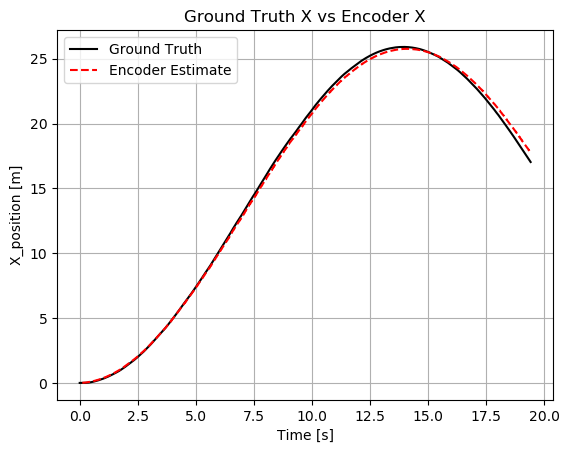

In [57]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position_x and encoder_x against Time
plt.plot(my_data['Time'].values, my_data['position_x'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_x'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('X_position [m]')
plt.title('Ground Truth X vs Encoder X')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_X.png")
# Show plot
plt.show()

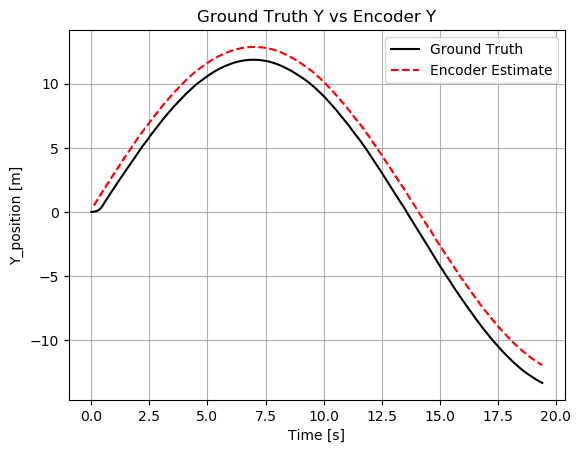

In [58]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position Y
plt.plot(my_data['Time'].values, my_data['position_y'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_y'].values,
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Y_position [m]')
plt.title('Ground Truth Y vs Encoder Y')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_Y.png")
# Show plot
plt.show()


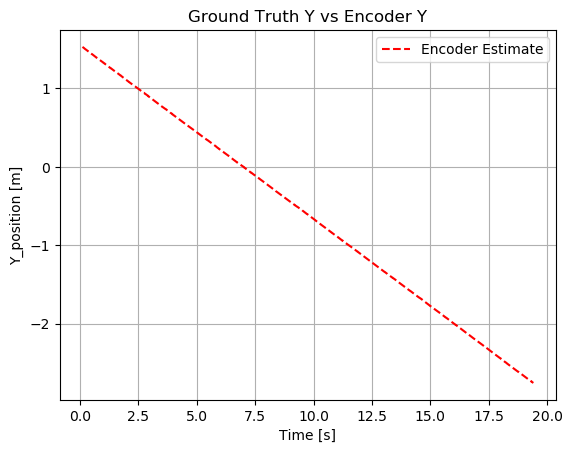

In [61]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position Y
# plt.plot(my_data['Time'].values, my_data['position_y'].values,
#         'k',
#         label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_theta'].values,
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.title('Ground Truth Theta vs Encoder Theta')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"orientation_Z.png")
# Show plot
plt.show()


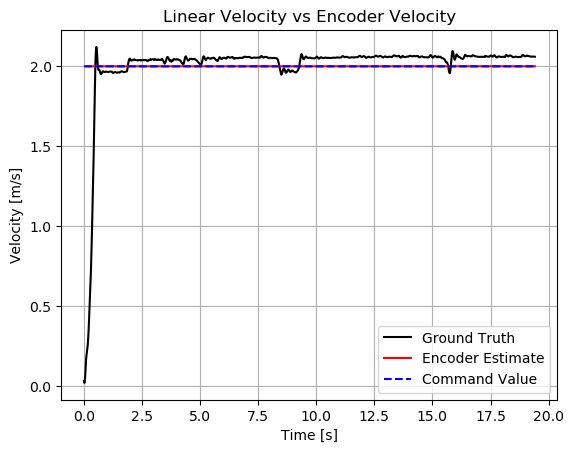

In [59]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both linear velocity and encoder velocity on the same plot
plt.plot(my_data['Time'].values, my_data['linear_velocity'].values, 
         'k',
         label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_velocity'].values, 
         'r',
         label='Encoder Estimate')
plt.plot(my_data['Time'].values, my_data['cmd_velocity'].values, 
         'b--',
         label='Command Value')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Linear Velocity vs Encoder Velocity')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"velocity.png")
# Show plot
plt.show()


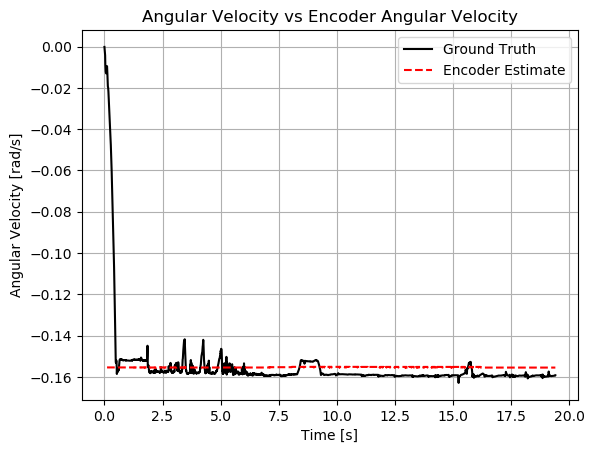

In [60]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both omega_z and encoder_omega on the same plot
plt.plot(my_data['Time'].values, my_data['omega_z'].values,
        'k', 
        label='Ground Truth')

plt.plot(my_data['Time'].values, my_data['encoder_omega'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Angular Velocity vs Encoder Angular Velocity')

# Add legend
plt.legend()

# Add grid
plt.grid(True)


# Save plot to file
plt.savefig(plot_save_path+"omega.png")
# Show plot
plt.show()
